# zipline MeanReversion 回测

在第 4 章中，我们介绍了“Zipline”来模拟从尾随横截面市场、基本面和另类数据计算 alpha 因子。

现在我们将利用上一章开发的自定义 MeanReversion 因子来利用 alpha 因子来导出买卖信号并对其采取行动。

## 导入

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import numpy as np
import pandas as pd
from pytz import UTC

from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)

from zipline import run_algorithm
from zipline.api import (attach_pipeline, 
                         date_rules, 
                         time_rules,
                         get_datetime,
                         order_target_percent,
                         pipeline_output, 
                         record, 
                         schedule_function, 
                         get_open_orders, 
                         calendars,
                         set_commission, 
                         set_slippage)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume

from pyfolio.utils import extract_rets_pos_txn_from_zipline

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

## 记录设置

In [4]:
# setup stdout logging
format_string = '[{record.time: %H:%M:%S.%f}]: {record.level_name}: {record.message}'
zipline_logging = NestedSetup([NullHandler(level=DEBUG),
                               StreamHandler(sys.stdout, format_string=format_string, level=INFO),
                               StreamHandler(sys.stderr, level=ERROR)])
zipline_logging.push_application()
log = Logger('Algorithm')

## 一些设置

In [5]:
# Settings
MONTH = 21
YEAR = 12 * MONTH
N_LONGS = 50
N_SHORTS = 50
VOL_SCREEN = 500

In [6]:
start = pd.Timestamp('2013-01-01', tz=UTC)
end = pd.Timestamp('2017-01-01', tz=UTC)
capital_base = 1e7

## 均值回归因子

In [7]:
class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())

## 创建管道

由 `compute_factors()` 方法创建的管道返回一个表，其中包含 25 只股票的长列和短列，这些股票的最后一个月的收益与其年平均值的负偏差和正偏差最大，并按标准差进行了归一化。它还将范围限制在过去 30 个交易日平均交易量最高的 500 只股票。

In [8]:
def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs'  : mean_reversion.bottom(N_LONGS),
                             'shorts' : mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))

Before_trading_start() 确保管道的每日执行和记录结果，包括当前价格信息。

In [9]:
def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')
    record(factor_data=context.factor_data.ranking)
    assets = context.factor_data.index
    record(prices=data.current(assets, 'price'))

## 设置再平衡

新的 rebalance() 方法将交易订单提交给 exec_trades() 方法，用于为管道标记为多头和空头头寸的资产，正负权重相等。它还剥离了不再包含在因子信号中的任何当前持有量：

In [10]:
def rebalance(context, data):
    """Compute long, short and obsolete holdings; place trade orders"""
    factor_data = context.factor_data
    assets = factor_data.index
    
    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = context.portfolio.positions.keys() - longs.union(shorts)
    log.info('{} | Longs: {:2.0f} | Shorts: {:2.0f} | {:,.2f}'.format(get_datetime().date(),
                                                                     len(longs), 
                                                                     len(shorts),
                                                                     context.portfolio.portfolio_value))

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS if N_LONGS else 0)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS if N_SHORTS else 0)

In [11]:
def exec_trades(data, assets, target_percent):
    """Place orders for assets using target portfolio percentage"""
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

## 初始化回测

`rebalance()` 方法根据 `schedule_function()` 实用程序在一周开始时设置的 `date_rules` 和 `time_rules` 运行，紧随内置 US_EQUITIES 日历规定的 market_open 之后（有关详细信息，请参阅文档于规则）。

您还可以指定相对金额和最低金额的交易佣金。还有一个选项可以定义滑点，这是交易决策和执行之间价格不利变化的成本

In [12]:
def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)

    set_commission(us_equities=commission.PerShare(cost=0.00075, 
                                                   min_trade_cost=.01))
    set_slippage(us_equities=slippage.VolumeShareSlippage(volume_limit=0.0025, 
                                                          price_impact=0.01))

## 运行算法

The algorithm executes upon calling the run_algorithm() function and returns the backtest performance DataFrame.

In [13]:
backtest = run_algorithm(start=start,
                         end=end,
                         initialize=initialize,
                         before_trading_start=before_trading_start,
                         bundle='quandl',
                         capital_base=capital_base)

[ 14:56:52.931442]: INFO: 2013-01-07 | Longs: 10 | Shorts:  2 | 10,000,000.00
[ 14:56:58.371509]: INFO: 2013-01-14 | Longs: 13 | Shorts:  3 | 10,027,422.36
[ 14:56:59.391627]: INFO: 2013-01-22 | Longs:  8 | Shorts:  5 | 10,097,663.57
[ 14:57:00.292112]: INFO: 2013-01-28 | Longs:  5 | Shorts: 14 | 10,106,150.06
[ 14:57:01.390799]: INFO: 2013-02-04 | Longs: 12 | Shorts: 11 | 10,135,417.26
[ 14:57:02.437827]: INFO: 2013-02-11 | Longs: 11 | Shorts: 13 | 10,182,644.42
[ 14:57:03.504983]: INFO: 2013-02-19 | Longs: 21 | Shorts: 11 | 10,127,755.45
[ 14:57:04.419533]: INFO: 2013-02-25 | Longs: 16 | Shorts:  8 | 10,180,357.23
[ 14:57:05.516497]: INFO: 2013-03-04 | Longs: 10 | Shorts: 10 | 10,200,300.19
[ 14:57:06.524370]: INFO: 2013-03-11 | Longs: 12 | Shorts:  7 | 10,240,453.13
[ 14:57:07.557706]: INFO: 2013-03-18 | Longs:  7 | Shorts:  7 | 10,150,394.01
[ 14:57:08.539824]: INFO: 2013-03-25 | Longs:  8 | Shorts:  7 | 10,149,029.25
[ 14:57:09.367086]: INFO: 2013-04-01 | Longs:  4 | Shorts:  6 | 

## 提取 pyfolio 输入

`pyfolio` 提供的`extract_rets_pos_txn_from_zipline` 实用程序提取用于计算性能指标的数据。

In [14]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)

## 保留与 pyfolio 一起使用的结果

In [15]:
with pd.HDFStore('backtests.h5') as store:
    store.put('backtest/equal_weight', backtest)
    store.put('returns/equal_weight', returns)
    store.put('positions/equal_weight', positions)
    store.put('transactions/equal_weight', transactions)

## 绘制结果

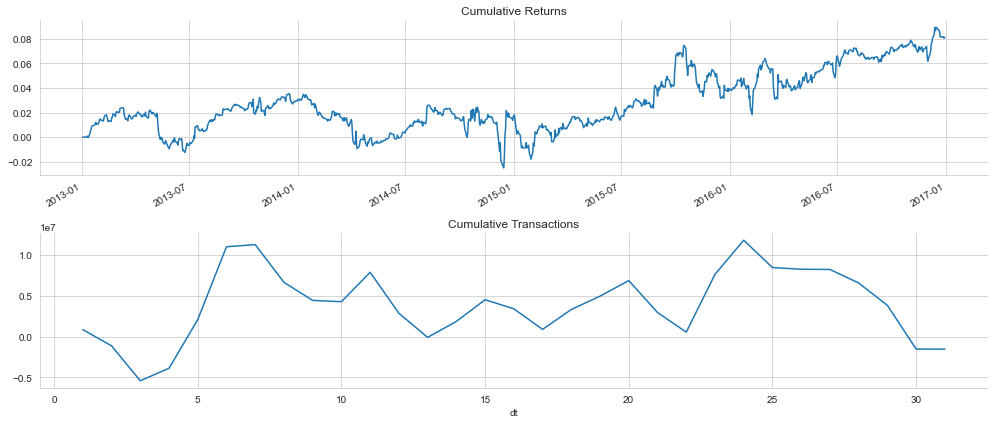

In [16]:
fig, axes= plt.subplots(nrows=2, figsize=(14,6))
returns.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Returns')
transactions.groupby(transactions.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[1], title='Cumulative Transactions')
fig.tight_layout()
sns.despine();

In [17]:
positions.index = positions.index.date

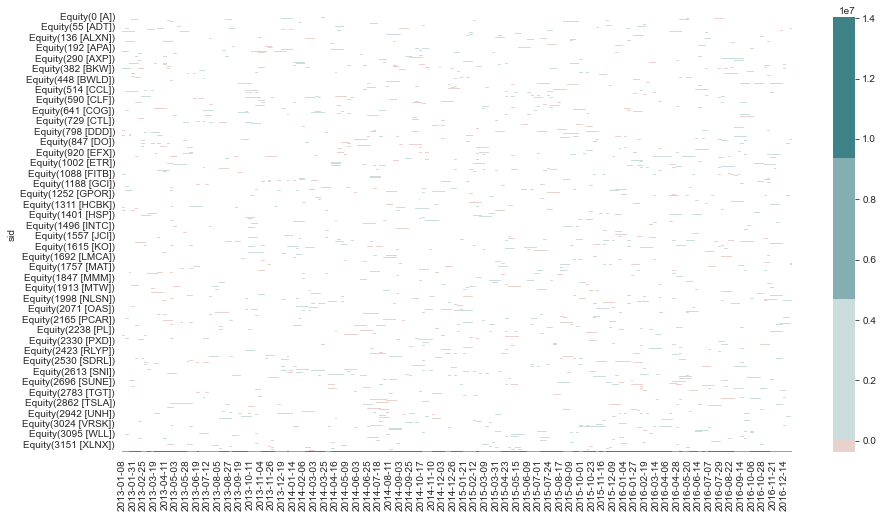

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(positions.replace(0, np.nan).dropna(how='all', axis=1).T, 
            cmap=sns.diverging_palette(h_neg=20, h_pos=200), ax=ax, center=0);

In [19]:
positions.head()

sid,Equity(0 [A]),Equity(1 [AA]),Equity(2 [AAL]),Equity(7 [AAP]),Equity(8 [AAPL]),Equity(12 [ABBV]),Equity(13 [ABC]),Equity(20 [ABT]),Equity(21 [ACAD]),Equity(27 [ACE]),...,Equity(3156 [XOM]),Equity(3162 [XPO]),Equity(3165 [XRX]),Equity(3171 [YELP]),Equity(3172 [YHOO]),Equity(3175 [YUM]),Equity(3180 [ZBH]),Equity(3194 [ZNGA]),Equity(3197 [ZTS]),cash
2013-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.441446e+06
2013-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.379079e+06
2013-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.379079e+06
2013-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.379079e+06
2013-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.379079e+06


In [20]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6505 entries, 2013-01-08 21:00:00+00:00 to 2016-12-30 21:00:00+00:00
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   sid          6505 non-null   object             
 1   symbol       6505 non-null   object             
 2   price        6505 non-null   float64            
 3   order_id     6502 non-null   object             
 4   amount       6505 non-null   int64              
 5   commission   0 non-null      object             
 6   dt           6505 non-null   datetime64[ns, UTC]
 7   txn_dollars  6505 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(4)
memory usage: 457.4+ KB
